## Measure time

In [1]:
import time
start_time = time.time()

## Reproducible results

In [11]:
from determinism import Determinism
determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")

Training results should now be reproducible.


## Setup dataset and hyperparameters
To investigate the impact of imbalanced training data on fine-tuning performance, we simulate class imbalance by restricting the training set to 20% of the images for each cat breed while keeping all dog images intact. We do not create a validation set as we are not tuning hyperparameters.

In [12]:
%reload_ext autoreload
%autoreload 2
from datasets import DatasetParams
from training import TrainParams, AdamParams
from augmentation import AugmentationParams

# Map breed to family (ex. 0 (Abbyssinian) to 0 (Cat))
breed_family_idx = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
                    1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    # Reduce cat data by 80 %
    class_fractions = tuple(0.2 if x == 0 else 1.0 for x in breed_family_idx),
    validation_set_fraction=0,  # no validation set
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
    validation_freq=0, # no validation set
)

## Experiments
Now we will conduct experiments comparing three configurations under the imbalanced training setup: (1) standard cross-entropy loss, (2) weighted cross-entropy loss, and (3) over-sampling of minority classes. Other parameters will remain fixed.

### 1. Standard cross-entropy loss
We check how much the test performance drops without any compensation.

In [10]:
from evaluation import evaluate_final_test_accuracy
evaluate_final_test_accuracy(dataset_params, baseline_params, determinism, trials=3)

Test size: 3669
Test Accuracy Mean: 83.71 %
Test Accuracy Standard Error: 0.20 percentage points


### Confusion matrix

In [13]:
from run import try_loading_trainer
from evaluation import evaluate_predictions, evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning
from tqdm import tqdm

suppress_weights_only_warning()

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(baseline_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=False,
    #worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)

print(f"Test size: {len(test_loader.dataset)}")

predicted, truth, _ = evaluate_predictions(trainer, test_loader, test_dataset)

breed_family_idx = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
                    1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]

test_acc = 100 * sum(x == y for x, y in zip(predicted, truth)) / len(predicted)
cats = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 0]
dogs = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 1]
cat_test_acc = 100 * sum(cats) / len(cats)
dog_test_acc = 100 * sum(dogs) / len(dogs)
print(f"Final test accuracy: {test_acc:.2f} %")
print(f"Final test accuracy for cats: {cat_test_acc:.2f} %")
print(f"Final test accuracy for dogs: {dog_test_acc:.2f} %")

families = list("Cat" if x == 0 else "Dog" for x in breed_family_idx)
breed_fam_names = [f"{name} ({fam})" for name, fam in zip(test_dataset.classes,families)]

Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

/home/jaxner/DD2424-project/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/3], Loss: 2.1290, Train Acc: 62.87%
Epoch [2/3], Loss: 0.7757, Train Acc: 90.29%
Epoch [3/3], Loss: 0.4629, Train Acc: 93.48%
Total elapsed: 222.98s, average per update step: 0.83s
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final test accuracy: 83.92 %
Final test accuracy for cats: 65.60 %
Final test accuracy for dogs: 92.64 %


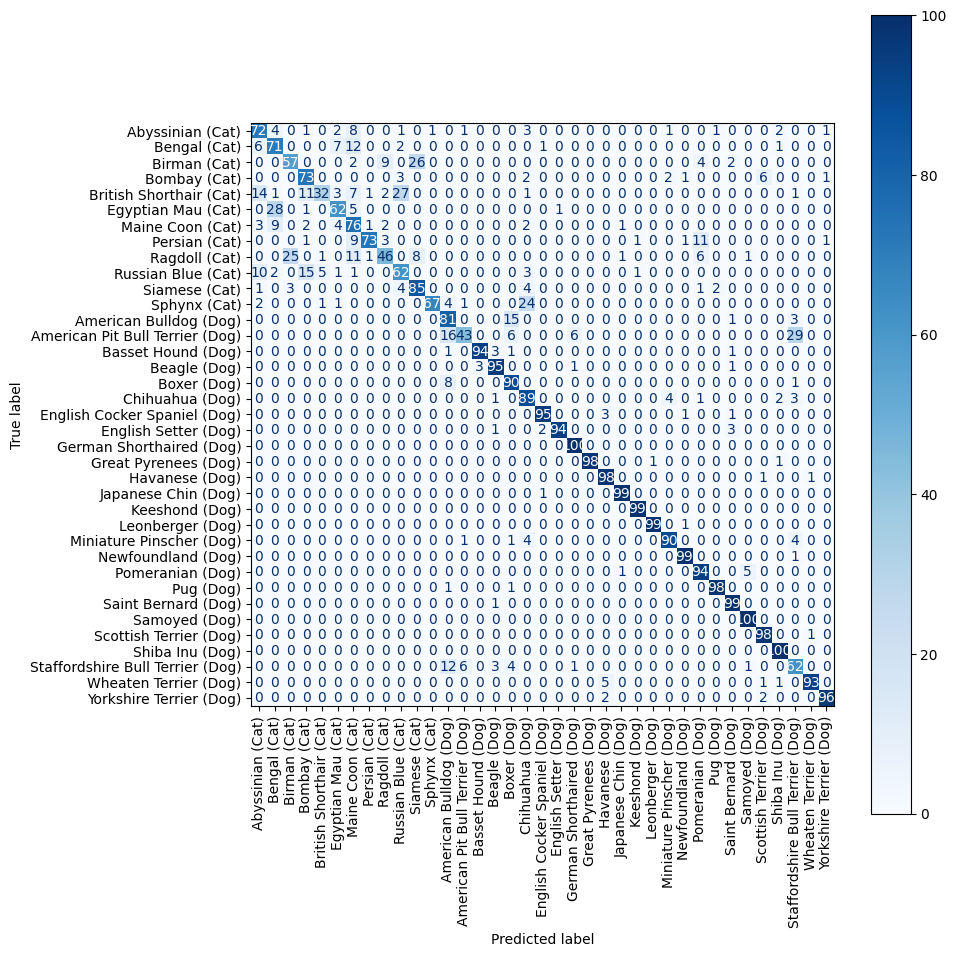

In [20]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Determine new order: cat classes first
cat_first_order = sorted(range(37), key=lambda i: breed_family_idx[i])

# Remap predictions and truths to new class order
old_to_new = {old: new for new, old in enumerate(cat_first_order)}
new_predicted = [old_to_new[p] for p in predicted]
new_truth = [old_to_new[t] for t in truth]
reordered_labels = list(range(37))
reordered_display_labels = [breed_fam_names[i] for i in cat_first_order]

# Compute and display confusion matrix
cm = confusion_matrix(new_truth, new_predicted, labels=reordered_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reordered_display_labels)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
plt.title("")
plt.tight_layout()
#plt.savefig("confusion_matrix.pdf", bbox_inches="tight")
plt.show()

### 2. Weighted cross-entropy loss
We add weights to the cross entropy loss function to compensate. Since we reduced the number of cats to 1/5, a natural weight to try is 5.

In [5]:
cat_vs_dog_ratio = 5
weights = tuple(
    cat_vs_dog_ratio if fam_idx == 0 else 1.0
    for fam_idx in breed_family_idx
)
baseline_params.loss_weights = weights
dataset_params.oversampling_weights = None
evaluate_final_test_accuracy(dataset_params, baseline_params, determinism, trials=3)

Test size: 3669
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

/home/jaxner/DD2424-project/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/3], Loss: 2.3536, Train Acc: 63.27%
Epoch [2/3], Loss: 0.9247, Train Acc: 91.31%
Epoch [3/3], Loss: 0.5488, Train Acc: 94.10%
Total elapsed: 388.45s, average per update step: 1.48s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 85.582 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.3485, Train Acc: 63.34%
Epoch [2/3], Loss: 0.9287, Train Acc: 90.95%
Epoch [3/3], Loss: 0.5429, Train Acc: 94.21%
Total elapsed: 389.48s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 85.010 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.3517, Train Acc: 63.67%
Epoch [2/3], Loss: 0.9264, Train Acc: 91.68%
Epoch [3/3], Loss: 0.5409, Train Acc: 93.95%
Total elapsed: 392.06s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 84.737 %
Test Accuracy Mean: 85.11 %
Test Accuracy Standard Error: 0.25 percentage points


### 3. Over-sampling of minority classes
Next we try oversampling.

In [6]:
baseline_params.loss_weights = None
dataset_params.oversampling_weights = weights
evaluate_final_test_accuracy(dataset_params, baseline_params, determinism, trials=3)

Test size: 3669
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

/home/jaxner/DD2424-project/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/3], Loss: 2.1325, Train Acc: 64.70%
Epoch [2/3], Loss: 0.7638, Train Acc: 93.11%
Epoch [3/3], Loss: 0.4216, Train Acc: 94.90%
Total elapsed: 391.27s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.108 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.1389, Train Acc: 63.49%
Epoch [2/3], Loss: 0.7745, Train Acc: 92.96%
Epoch [3/3], Loss: 0.4432, Train Acc: 95.01%
Total elapsed: 390.45s, average per update step: 1.49s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.653 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.1272, Train Acc: 66.09%
Epoch [2/3], Loss: 0.7501, Train Acc: 94.57%
Epoch [3/3], Loss: 0.4159, Train Acc: 95.53%
Total elapsed: 391.36s, average per update step: 1.49s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.163 %
Test Accuracy Mean: 87.31 %
Test Accuracy Standard Error: 0.17 percentage points


### 4. Both
Finally we try both at the same time, using the same weight for both.

In [7]:
baseline_params.loss_weights = weights
dataset_params.oversampling_weights = weights
evaluate_final_test_accuracy(dataset_params, baseline_params, determinism, trials=3)

Test size: 3669
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

/home/jaxner/DD2424-project/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/3], Loss: 2.0150, Train Acc: 50.40%
Epoch [2/3], Loss: 0.7323, Train Acc: 91.02%
Epoch [3/3], Loss: 0.3800, Train Acc: 94.39%
Total elapsed: 391.93s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.299 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.0266, Train Acc: 50.00%
Epoch [2/3], Loss: 0.7332, Train Acc: 91.09%
Epoch [3/3], Loss: 0.3969, Train Acc: 94.28%
Total elapsed: 390.64s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.953 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.0277, Train Acc: 51.43%
Epoch [2/3], Loss: 0.7260, Train Acc: 92.56%
Epoch [3/3], Loss: 0.3820, Train Acc: 94.57%
Total elapsed: 391.94s, average per update step: 1.50s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 87.463 %
Test Accuracy Mean: 87.57 %
Test Accuracy Standard Error: 0.20 percentage points


## Time elapsed

In [8]:
elapsed = time.time() - start_time
print(f"Total elapsed time: {elapsed:.2f} seconds")

Total elapsed time: 6863.60 seconds
